# Simulated Galaxies: The Return (New Galaxies)

What we want in this notebook is to create and test several schemes to generate galaxy images. 

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import galsim
import tensorflow as tf
import tensorflow_datasets as tfds
import autometacal
import tqdm
import os
from astropy.table import Table

In [75]:
cat = galsim.COSMOSCatalog(dir = os.path.expanduser('~/Data/COSMOS_25.2_training_sample'))
catable=Table(cat.param_cat)
catable

IDENT,mag_auto,flux_radius,zphot,sersicfit [8],bulgefit [16],fit_status [5],fit_mad_s,fit_mad_b,fit_dvc_btt,use_bulgefit,viable_sersic,hlr [3],flux [4]
int32,float64,float64,float64,float64,float64,int32,float64,float64,float64,int32,int32,float64,float64
1286742,25.074556350708008,5.665686130523682,0.9444000124931335,0.013805730165296373 .. 0.7271818199862898,0.013722619128874446 .. 0.8261436144591823,1 .. 1,0.002050128135597444,0.0020607960657673327,0.0022140486678908027,0,1,0.10870585950506657 .. 0.0,2.1602487977063904 .. 0.0
782514,24.985071182250977,5.427647113800049,1.4241000413894653,0.014409754401637312 .. 2.412473286905461,0.012780175388374785 .. -0.8580977101162014,1 .. 1,0.00294126016306956,0.003090797056980981,0.47342119317981024,0,1,0.0974461731996633 .. 0.0,2.699868382752252 .. 0.0
52167,23.126625061035156,14.171381950378418,1.0190000534057617,0.00721210624489112 .. 1.2718716075894045,0.005778727948074379 .. 1.9695011915783498,1 .. 1,0.0027478740052489627,0.002724644497289763,0.037447996074410954,0,1,0.3842748018398006 .. 0.0,13.761680581733447 .. 0.0
70378,23.61808204650879,13.591012954711914,1.0312000513076782,0.006534871271120474 .. 0.45811157491022814,0.0040667777411650735 .. 0.5284126159980042,1 .. 1,0.0021667774104480782,0.002295922202999617,0.0,0,1,0.3586576280712098 .. 0.0,8.280230201407937 .. 0.0
1108730,24.99716567993164,6.59538459777832,1.7522000074386597,0.016248464637488275 .. 0.6580086082499662,0.008625983269181311 .. -1.7052708449727527,1 .. 1,0.003077972603879063,0.003612341885244324,3.0943092548182787e-18,0,1,0.13974938920002375 .. 0.0,2.7105833863623645 .. 0.0
67307,23.807924270629883,8.664006233215332,1.624400019645691,0.017653408361451385 .. 0.9725261193518764,0.01518385073604151 .. 1.7442607426307692,1 .. 1,0.002448468718946181,0.0024542576387947615,0.0062307669339586105,0,1,0.17153760481688798 .. 0.0,6.246499389168932 .. 0.0
466881,25.005207061767578,5.1761698722839355,0.847599983215332,0.012771093093837576 .. 1.0495588409113927,0.0075243214098179 .. 0.6071743951945785,1 .. 1,0.0020499230901729927,0.0018489873128187777,0.39297642584128606,1,1,0.10841086146054124 .. 0.12456734741574446,2.5316978910352583 .. 2.600197556302195
1007568,24.15331268310547,16.072845458984375,1.432800054550171,0.002171383714997691 .. 0.24026111767708222,0.0011669668580383172 .. 0.7176431857570683,1 .. 1,0.0031848260006461025,0.0026981961869623774,0.019939971199413205,0,1,0.49243971404343245 .. 0.0,4.535268860380321 .. 0.0
375923,25.04447364807129,6.306777477264404,0.20649999380111694,0.01117238352055494 .. 1.7567859582964158,0.008306849804422669 .. -2.2242346318701234,1 .. 1,0.0018002365812593586,0.0018954697573489937,0.0,0,1,0.14608723773105015 .. 0.0,2.3560191716091263 .. 0.0


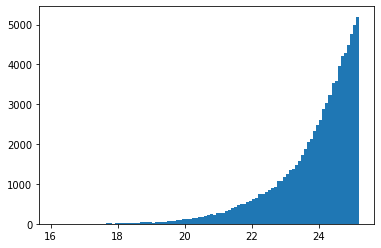

In [4]:
hist(catable['mag_auto'],bins=100);

TypeError: makeGalaxy() got an unexpected keyword argument 'nx'

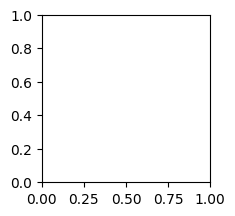

In [18]:
style.use('default')
figure(figsize=(10,10))
j=0
i=0
while i <16:
  subplot(4,4,i+1)
  if cat.param_cat[j][1]<18:
    
    gal = cat.makeGalaxy(index=j,gal_type='real')
    gal_image = gal.gal_image.array
    imshow(gal_image)
    title(f'j={j}',fontsize=8)
    i=i+1
  j=j+1

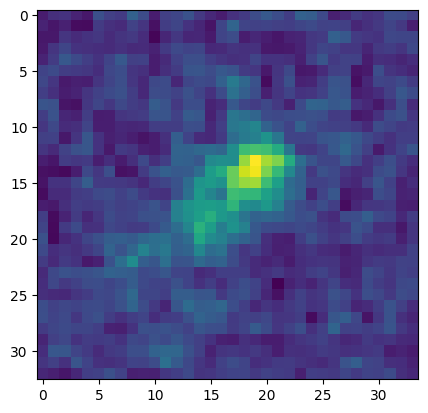

In [27]:
gal = cat.makeGalaxy(index=1,gal_type='real')
gal_image = gal.gal_image.array
imshow(gal_image)

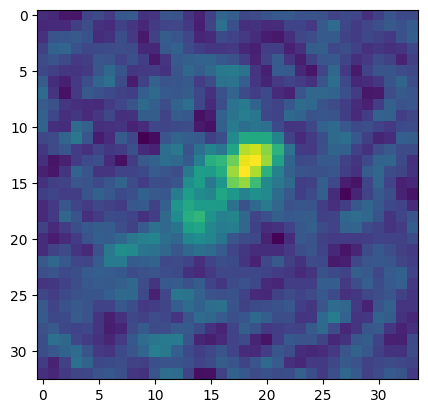

In [61]:
psf = galsim.Kolmogorov(fwhm=.098).withFlux(1.0)
obs = galsim.Convolve([[gal,psf]])
imshow(obs.drawImage(nx=34,ny=33).array)

In [73]:
def paratest(j,mag):
  psf_fwhm = .65 # arcsec
  sky_level = 400 # ADU (~variance)
  pixel_scale = 0.187 # arcsec/pixel
  mag_zp = 32
  gal_mag = 23
  seed = 1234
  gal_rng = galsim.BaseDeviate(1234)

  gal_flux = 10**(-(gal_mag-mag_zp)/2.5)

  psf = galsim.Kolmogorov(fwhm=psf_fwhm).withFlux(1.0)
  gal = cat.makeGalaxy(index=j,gal_type='parametric').withFlux(gal_flux)

  obj = galsim.Convolve((psf, gal))
  img = obj.drawImage(nx=51, ny=51, scale=pixel_scale, method='fft')

  # Get snr
  S2 = np.sum(img.array**2)
  s2n = np.sqrt(S2/sky_level)

  noise = galsim.GaussianNoise(sigma=np.sqrt(sky_level), rng=gal_rng)
  img.addNoise(noise) # it updates directly the galsim object. It returns
                      # the variance if I remember well..

  #print(f"s2n: {s2n} (in galsim system)")
  return s2n ,img.array

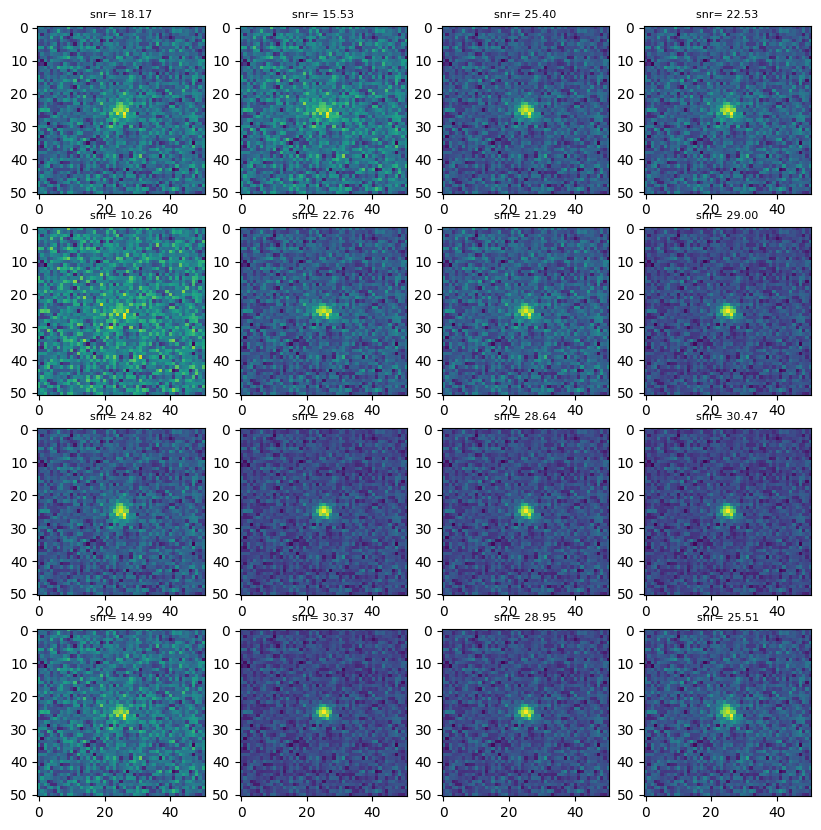

In [74]:
style.use('default')
figure(figsize=(10,10))
j=0
i=0
choices=random.choice(len(cat.param_cat),16)
while i <16:
  subplot(4,4,i+1)
  if cat.param_cat[j][1]<23:
    snr, gal_image = paratest(j,cat.param_cat[j][1])
   
    imshow(gal_image)
    title(f'snr={snr : .2f}',fontsize=8)
    i=i+1
  j=j+1

In [66]:
def make_COSMOS(Ngals, gal_size=51, psf_size=51):
  cat = galsim.COSMOSCatalog(dir = os.path.expanduser('~/Data/COSMOS_25.2_training_sample'))
  gal_list = []
  psf_list = []
  n=0
  list_length = 0
  while list_length < Ngals:
    gal=cat.makeGalaxy(n)
        
    if (
      (min(gal.original_gal.image.array.shape) >= gal_size) & 
      (min(gal.psf_image.array.shape) >= psf_size) 
    ):
      centre_x_gal = gal.original_gal.image.array.shape[0]//2
      centre_y_gal = gal.original_gal.image.array.shape[1]//2
      
      centre_x_psf = gal.psf_image.array.shape[0]//2
      centre_y_psf = gal.psf_image.array.shape[1]//2
      
      psf_image = tf.convert_to_tensor(gal.psf_image.array[centre_x_psf - psf_size //2 :
                                                           centre_x_psf + 1 + psf_size //2 ,
                                                           centre_y_psf - psf_size //2 :
                                                           centre_y_psf + 1 + psf_size //2 ],
                                       dtype=tf.float32)
      gal_image = tf.convert_to_tensor(gal.gal_image.array[centre_x_gal - gal_size //2 :
                                                           centre_x_gal + 1  + gal_size //2,
                                                           centre_y_gal - gal_size //2 :
                                                           centre_y_gal + 1 + gal_size //2 ],
                                       dtype=tf.float32)
      gal_list.append(gal_image)
      psf_list.append(psf_image)
      list_length += 1
      
    else:
      print(min(gal.original_gal.image.array.shape),min(gal.psf_image.array.shape),end="\r")
    n += 1
    
      
  print()
  print(n)
  gal_image_stack = tf.stack(gal_list)
  psf_image_stack = tf.stack(psf_list)
  return gal_image_stack, psf_image_stack

In [67]:
gal_images, psf_images = make_COSMOS(16)

25 51
30


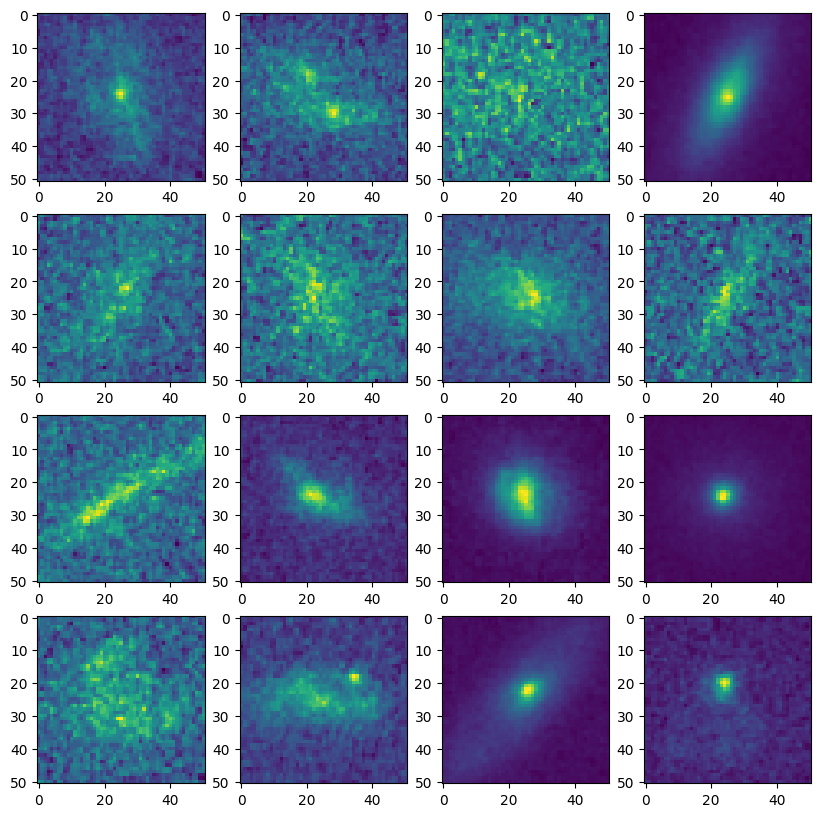

In [68]:
style.use('default')
figure(figsize=(10,10))
for i in range(16):
  subplot(4,4,i+1)
  imshow(gal_images[i])

# Autodiff Test

In [ ]:
def line_and_contours(lines,percentiles=[2.5,16,50,84,97.5]):
  line_and_contours = np.percentile(lines,percentiles,axis=1)
  return line_and_contours

In [ ]:
steps = logspace(-5,0,100)

In [ ]:
reconv_psf = galsim.Moffat(beta=2.5, 
                    fwhm=0.9*1.2)
reconv_psf_image = tf.expand_dims(tf.convert_to_tensor(
  reconv_psf.drawImage(nx=51, 
                       ny=51, 
                       scale=.2).array),axis=0)

In [ ]:
def get_ellipticities(image):
  return autometacal.gaussian_moments(image,0.2,1.2)

In [ ]:
e_finite_list = []
R_finite_list = []
for step in tqdm.tqdm(steps):
    e_finite, R_finite = autometacal.metacal.get_metacal_response_finitediff(gal_images,
                                                         psf_images,
                                                         reconv_psf_image,
                                                         step=step,method=get_ellipticities)
    e_finite_list.append(e_finite)
    R_finite_list.append(R_finite)
    
R_finite=np.array(R_finite_list)

In [ ]:
e_auto, R_auto = autometacal.get_metacal_response(gal_images[:2500],psf_images[:2500],reconv_psf_image,get_ellipticities)
calibre_f=tf.linalg.inv(R_auto[:]) @ tf.reshape(e_auto,[-1,2,1])

In [ ]:
figure(figsize=(20,8))
subplot(122)
hist(R_auto[:,0,0].numpy()[abs(e_auto[:,0])<1],bins=100,density=True,label="$R_{11}$");
hist(R_auto[:,1,1].numpy()[abs(e_auto[:,0])<1],bins=100,density=True,label="$R_{22}$",alpha=.7);
title("autometacal response matrix (1k obj),  diagonal",fontsize=20)
legend(fontsize=20)
subplot(121)
hist(R_auto[:,1,0].numpy()[abs(e_auto[:,0])<1],bins=100,label="$R_{21}$",density=True);
hist(R_auto[:,0,1].numpy()[abs(e_auto[:,0])<1],bins=100,label="$R_{12}$",density=True,alpha=.7);
title("autometacal response matrix (1k obj), off diagonal",fontsize=20)
legend(fontsize=20)
savefig('response_simple.png',bbox_inches='tight')

In [ ]:
style.use('ggplot')

figure(figsize=(16,5))
subplot(121)

Y00_95, Y00_84, Y00_median, Y00_16, Y00_5 = line_and_contours(abs(R_auto[:,0,0]-R_finite[:,:,0,0]))
fill_between(steps, Y00_5,Y00_95,color='red',alpha=0.1)####CL95
fill_between(steps, Y00_16,Y00_84,color='red',alpha=0.3)####CL68
plot(steps,Y00_median,label="R_{11}",color='red')####Median 

Y11_95, Y11_84, Y11_median, Y11_16, Y11_5 = line_and_contours(abs(R_auto[:,1,1]-R_finite[:,:,1,1]))
fill_between(steps, Y11_5,Y11_95,color='darkblue',alpha=0.1)####CL95
fill_between(steps, Y11_16,Y11_84,color='darkblue',alpha=0.3)####CL68
plot(steps,Y11_median,label="R_{22}",color='darkblue')####Median 
plot([1e-2,1e-2],[1e-6,1e-1],'k-')

ylim([1e-6,1e-1])
xlabel('step size',fontsize=20)
ylabel('$R_{auto}$ - $R_{finite}$',fontsize=20)
legend()
xscale('log')
yscale('log')

subplot(122)

Y10_95, Y10_84, Y10_median, Y10_16, Y10_5 = line_and_contours(abs(R_auto[:,1,0]-R_finite[:,:,1,0]))
fill_between(steps, Y10_5,Y10_95,color='red',alpha=0.1)####CL95
fill_between(steps, Y10_16,Y10_84,color='red',alpha=0.3)####CL68
plot(steps,Y10_median,label="R_{21}",color='red')####Median 

Y01_95, Y01_84, Y01_median, Y01_16, Y01_5 = line_and_contours(abs(R_auto[:,0,1]-R_finite[:,:,0,1]))
fill_between(steps, Y01_5,Y01_95,color='darkblue',alpha=0.1)####CL95
fill_between(steps, Y01_16,Y01_84,color='darkblue',alpha=0.3)####CL68
plot(steps,Y01_median,label="R_{12}",color='darkblue')####Median 

plot([1e-2,1e-2],[1e-6,1e-1],'k-')

ylim([1e-6,1e-1])
xlabel('step size',fontsize=20)
ylabel("$R_{auto}$ - $R_{finite}$",fontsize=20)
legend()
xscale('log')
yscale('log')
savefig('simple.png',bbox_inches='tight')